**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ sklearn 0.20.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Предобработка данных и логистическая регрессия для задачи бинарной классификации

## Programming assignment

В задании вам будет предложено ознакомиться с основными техниками предобработки данных, а так же применить их для обучения модели логистической регрессии. Ответ потребуется загрузить в соответствующую форму в виде 6 текстовых файлов.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [3]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y.
Теперь X обозначает обучающую выборку, y - ответы на ней

In [4]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Теория по логистической регрессии

После осознания того, какую именно задачу требуется решить на этих данных, следующим шагом при реальном анализе был бы подбор подходящего метода. В данном задании выбор метода было произведён за вас, это логистическая регрессия. Кратко напомним вам используемую модель.

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

где:
- $\pi_{ik}$ - вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$
- $\theta$ - внутренние параметры алгоритма, которые настраиваются в процессе обучения, в случае логистической регрессии - $w, b$

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Для многих параметров, логистическая функция будет: 

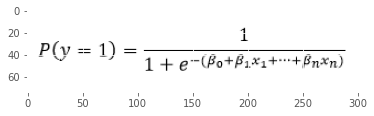

In [32]:
# ipython image insert code
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
pil_im = Image.open('logit-function.png', 'r')
imshow(np.asarray(pil_im))

Параметры $w$ и $b$ находятся, как решения следующей задачи оптимизации (указаны функционалы с L1 и L2 регуляризацией, с которыми вы познакомились в предыдущих заданиях):

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - это стандартный гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные.

## Предобработка данных

Из свойств данной модели следует, что:
- все $X$ должны быть числовыми данными (в случае наличия среди них категорий, их требуется некоторым способом преобразовать в вещественные числа)
- среди $X$ не должно быть пропущенных значений (т.е. все пропущенные значения перед применением модели следует каким-то образом заполнить)

Поэтому базовым этапом в предобработке любого датасета для логистической регрессии будет кодирование категориальных признаков, а так же удаление или интерпретация пропущенных значений (при наличии того или другого).

In [6]:
data.head()

Grant.Status Sponsor.Code Grant.Category.Code  \
0             1          21A                 50A   
1             1           4D                 10A   
2             0          NaN                 NaN   
3             0          51C                 20C   
4             0          24D                 30B   

  Contract.Value.Band...see.note.A  RFCD.Code.1  RFCD.Percentage.1  \
0                               A      230202.0               50.0   
1                               D      320801.0              100.0   
2                              NaN     320602.0               50.0   
3                               A      291503.0               60.0   
4                              NaN     380107.0              100.0   

   RFCD.Code.2  RFCD.Percentage.2  RFCD.Code.3  RFCD.Percentage.3  ...  \
0     230203.0               30.0     230204.0               20.0  ...   
1          0.0                0.0          0.0                0.0  ...   
2     321004.0               30.0     321015.0               20.0  ...   
3     321402.0               40.0          0.0                0.0  ...   
4          0.0                0.0          0.0                0.0  ...   

   Dept.No..1  Faculty.No..1  With.PHD.1  \
0      3098.0           31.0        Yes    
1      2553.0           25.0        Yes    
2      2813.0           25.0         NaN   
3      2553.0           25.0         NaN   
4      2923.0           25.0         NaN   

   No..of.Years.in.Uni.at.Time.of.Grant.1  Number.of.Successful.Grant.1  \
0                                >=0 to 5                           2.0   
1                                >=0 to 5                           3.0   
2                             Less than 0                           1.0   
3                            more than 15                           2.0   
4                             Less than 0                           0.0   

   Number.of.Unsuccessful.Grant.1  A..1  A.1  B.1  C.1  
0                             0.0   0.0  4.0  2.0  0.0  
1                             1.0   0.0  2.0  0.0  0.0  
2                             5.0   0.0  7.0  2.0  0.0  
3                             1.0   5.0  6.0  9.0  1.0  
4                             2.0   0.0  0.0  0.0  0.0  

[5 rows x 39 columns]

Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [7]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))
categorical_cols

['Role.1',
 'A.1',
 'RFCD.Code.5',
 'SEO.Code.3',
 'A..1',
 'Home.Language.1',
 'SEO.Code.2',
 'Grant.Category.Code',
 'SEO.Code.4',
 'Faculty.No..1',
 'No..of.Years.in.Uni.at.Time.of.Grant.1',
 'Person.ID.1',
 'RFCD.Code.3',
 'SEO.Code.5',
 'Dept.No..1',
 'RFCD.Code.4',
 'C.1',
 'Sponsor.Code',
 'Country.of.Birth.1',
 'SEO.Code.1',
 'With.PHD.1',
 'RFCD.Code.2',
 'RFCD.Code.1',
 'Contract.Value.Band...see.note.A',
 'B.1']

Также в нём присутствуют пропущенные значения. Очевидны решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [8]:
data.dropna().shape

(213, 39)

In [33]:
print('X shape before drop NaN', X.shape, 'X shape after drop NaN', X.dropna().shape)

X shape before drop NaN (6000, 38) X shape after drop NaN (213, 38)


Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

##  Задание 0. Обработка пропущенных значений.
1. Заполните пропущенные вещественные значения в X нулями и средними по столбцам, назовите полученные датафреймы X_real_zeros и X_real_mean соответственно. Для подсчёта средних используйте описанную ниже функцию calculate_means, которой требуется передать на вход вешественные признаки из исходного датафрейма. **Для подсчета среднего можно использовать функцию pandas.mean()**
2. Все категориальные признаки в X преобразуйте в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA'), полученный датафрейм назовите X_cat.

Для объединения выборок здесь и далее в задании рекомендуется использовать функции

    np.hstack(...)
    np.vstack(...)

In [34]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [37]:
X_numeric_data = X[numeric_cols]
print('numeric_data.shape:' , X_numeric_data.shape)
print('Sum of NaN in numeric_data:', X_numeric_data.isnull().sum().sum(), '\n-------|------\n')

numeric_data.shape: (6000, 13)
Sum of NaN in numeric_data: 5379 
-------|------



In [38]:
def _means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    #print('means.shape:', means.shape)
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        #print('to_sum:\n', to_sum)        
        indices = numeric_data.iloc[:,j].notnull().to_numpy().nonzero()[0]
        #print('indices: ', indices)
        correction = np.amax(to_sum[indices])
        #print('correction: ', correction)
        if correction != 0:
            to_sum /= correction
            #print('to_sum after correction:\n', to_sum) 
            for i in indices:
                means[j] += to_sum[i]
            means[j] /= indices.size
            means[j] *= correction
        else:
            pass 
        #print('j:', j , '  mean[j]:', means[j], '\n ---------------------')
    return pd.Series(means, numeric_data.columns)

mean_values = _means(X_numeric_data)
print(mean_values, '\nmean shape:', mean_values.shape)

RFCD.Percentage.1                   74.832348
RFCD.Percentage.2                   17.677593
RFCD.Percentage.3                    6.933011
RFCD.Percentage.4                    0.437937
RFCD.Percentage.5                    0.119112
SEO.Percentage.1                    71.483240
SEO.Percentage.2                    20.646880
SEO.Percentage.3                     6.926704
SEO.Percentage.4                     0.730804
SEO.Percentage.5                     0.212192
Year.of.Birth.1                   1962.449849
Number.of.Successful.Grant.1         1.177849
Number.of.Unsuccessful.Grant.1       2.097977
dtype: float64 
mean shape: (13,)


In [39]:
def change_NaN_values_to_zeros(data_frame, attributes):
    return_table = data_frame.copy()
    for j in range(len(attributes)):
        nan_array = np.isnan(data_frame[attributes[j]])
        for i in range(return_table[attributes[j]].shape[0]):
            if (nan_array[i]):
                return_table[attributes[j]][i] = 0
    return return_table

def change_NaN_values_to_mean_values(data_frame, attributes, means):
    return_table = data_frame.copy()
    for j in range(len(attributes)):
        nan_array = np.isnan(data_frame[attributes[j]])
        for i in range(return_table[attributes[j]].shape[0]):
            if (nan_array[i]):
                return_table[attributes[j]][i] = means[attributes[j]]
    return return_table

X_real_zeros = change_NaN_values_to_zeros(X_numeric_data, numeric_cols)
X_real_mean = change_NaN_values_to_mean_values(X_numeric_data, numeric_cols, mean_values) 
 
 
#X_real_zeros.head(30)
#X_real_mean.head(30)

In [43]:
print( X[categorical_cols].head(2) )
# transform
X_cat = X[categorical_cols].astype('string')
X_cat.fillna('NAN', inplace=True)
print( X_cat.dtypes ) # X[categorical_cols].dtypes  )
print( X_cat.head(30))

               Role.1  A.1  RFCD.Code.5  SEO.Code.3  A..1 Home.Language.1  \
0  CHIEF_INVESTIGATOR  4.0          0.0         0.0   0.0             NaN   
1  CHIEF_INVESTIGATOR  2.0          0.0         0.0   0.0             NaN   

   SEO.Code.2 Grant.Category.Code  SEO.Code.4  Faculty.No..1  ... RFCD.Code.4  \
0         0.0                 50A         0.0           31.0  ...         0.0   
1         0.0                 10A         0.0           25.0  ...         0.0   

   C.1  Sponsor.Code  Country.of.Birth.1  SEO.Code.1  With.PHD.1  RFCD.Code.2  \
0  0.0           21A           Australia    780101.0        Yes      230203.0   
1  0.0            4D           Australia    730112.0        Yes           0.0   

  RFCD.Code.1 Contract.Value.Band...see.note.A  B.1  
0    230202.0                               A   2.0  
1    320801.0                               D   0.0  

[2 rows x 25 columns]
Role.1                                    string
A.1                                       stri

In [44]:
X_res = np.hstack((X_real_mean, X_cat)) # we join real and categorical features values
print(X_res[0, :]) # this is now Numpy array, without column headings
print('Res shape:', X_res.shape)

[50.0 30.0 20.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0 1965.0 2.0 0.0
 'CHIEF_INVESTIGATOR' '4.0' '0.0' '0.0' '0.0' 'NAN' '0.0' '50A' '0.0'
 '31.0' '>=0 to 5' '493297.0' '230204.0' '0.0' '3098.0' '0.0' '0.0' '21A'
 'Australia' '780101.0' 'Yes ' '230203.0' '230202.0' 'A ' '2.0']
Res shape: (6000, 38)


In [41]:
# filling NaN with mean by columns example
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[2, 10], [np.nan, 10], [2, 1]])
t = [[np.nan, 0], [6, np.nan], [7, 6]]
print(imp.transform(t))

[[2. 0.]
 [6. 7.]
 [7. 6.]]


## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
print('\n', encoder)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)

Исходные данные:

      sex nationality
0    male    American
1  female    European
2    male       Asian
3  female    European

 DictVectorizer(sparse=False)

Закодированные данные:

[[1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]]


Как видно, в первые три колонки оказалась закодированна информация о стране, а во вторые две - о поле. При этом для совпадающих элементов выборки строки будут полностью совпадать. Также из примера видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет информацию, в том числе о наличии пропущенных значений (их наличие просто становится одним из бинарных признаков в преобразованных данных).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки данных интерфейс. Функция

    encoder.fit_transform(X)
    
позволяет вычислить необходимые параметры преобразования, впоследствии к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то получите вообще говоря разные коды для одних и тех же признаков, и ваше решение работать не будет.

Также параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что иначе подсчитанные на тесте метрики качества будут давать смещённые оценки на качество работы алгоритма. Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [45]:
X_cat.T.to_dict()[0].values()

dict_values(['CHIEF_INVESTIGATOR', '4.0', '0.0', '0.0', '0.0', 'NAN', '0.0', '50A', '0.0', '31.0', '>=0 to 5', '493297.0', '230204.0', '0.0', '3098.0', '0.0', '0.0', '21A', 'Australia', '780101.0', 'Yes ', '230203.0', '230202.0', 'A ', '2.0'])

In [47]:
# one hot encoding
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [52]:
print('X categorial, shape:', X_cat.shape)
print('X categorial with one-hot encoded, shape:', X_cat_oh.shape)
print('X Real zeros, shape:', X_real_zeros.shape)
print('X Real mean, shape:', X_real_mean.shape)

X categorial, shape: (6000, 25)
X categorial with one-hot encoded, shape: (6000, 5593)
X Real zeros, shape: (6000, 13)
X Real mean, shape: (6000, 13)


In [21]:
print(X_cat_oh[0, :], len(X_cat_oh[0]))

[1. 0. 0. ... 0. 0. 1.] 5593


Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

Обращаем внимание на заданный параметр для генератора случайных чисел: random_state. Так как результаты на обучении и тесте будут зависеть от того, как именно вы разделите объекты, то предлагается использовать заранее определённое значение для получение результатов, согласованных с ответами в системе проверки заданий.

In [53]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

## Описание классов

Итак, мы получили первые наборы данных, для которых выполнены оба ограничения логистической регрессии на входные данные: 
(1) числовые данные и (2) не должно быть пропущенных значений.
Обучим на них регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator - обучающий алгоритм, для которого будет производиться подбор параметров
- param_grid - словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения - набор параметров для перебора

Данный класс выполняет **кросс-валидацию обучающей выборки для каждого набора параметров** и находит те, на которых алгоритм работает лучше всего. Этот метод позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring - функционал качества, максимум которого ищется кросс валидацией, по умолчанию используется функция score() класса esimator
- n_jobs - позволяет ускорить кросс-валидацию, выполняя её параллельно, число определяет количество одновременно запущенных задач
- cv - количество фолдов, на которые разбивается выборка при кросс-валидации

После инициализации класса GridSearchCV, процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения предсказаний можно пользоваться функцией

    optimizer.predict(X)
    
для меток или

    optimizer.predict_proba(X)
    
для вероятностей (в случае использования логистической регрессии).
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ - лучший алгоритм
- best\_params\_ - лучший набор параметров

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
где penalty принимает либо значение 'l2', либо 'l1'. По умолчанию устанавливается значение 'l2', и везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с L2-регуляризацией.

## Задание 1. Сравнение способов заполнения вещественных пропущенных значений.
1. Составьте две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними. Рекомендуется записывать в выборки сначала вещественные, а потом категориальные признаки.

In [54]:
X_train_mean_cat = np.hstack((X_train_real_mean, X_train_cat_oh)) # we join real and categorical features values
X_test_mean_cat = np.hstack((X_test_real_mean, X_test_cat_oh))
#print(X_res_mean[0, :]) # this is now Numpy array, without column headings
print('X_train_mean_cat shape :', X_train_mean_cat.shape)

X_train_mean_cat shape : (4200, 5606)


In [55]:
X_train_zeros_cat = np.hstack((X_train_real_zeros, X_train_cat_oh)) # we join real and categorical features values
X_test_zeros_cat = np.hstack((X_test_real_zeros, X_test_cat_oh))
#print(X_res_zeros[0, :]) # this is now Numpy array, without column headings
print('X_train_zeros_cat shape:', X_train_zeros_cat.shape) 
#print('X_test_zeros_cat shape:', X_test_zeros_cat.shape) 

X_train_zeros_cat shape: (4200, 5606)


2. Обучите на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3. **При обучении использовать параметр solver='lbfgs' в этом и последующих заданиях ноутбука.**

In [103]:
from sklearn import model_selection, linear_model
estimator = linear_model.LogisticRegression(random_state = 0, 
                  n_jobs =3,  penalty = "l2", solver='liblinear') #, solver='lbfgs') # solver='liblinear'
# B первом задании, если указывать  solver='lbfgs' , то ответ не принимается, без этого указания - все хорошо. 
estimator.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': 3,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [117]:
param_grid = {
    "C" : [0.5,  1],
    "intercept_scaling" : [0.001, 0.01, 0,1],
    "tol" : [0.001, 0.05],
}
optimizer_zeros = model_selection.GridSearchCV(estimator, param_grid, cv = 3)

In [27]:
#optimizer_zeros.roc_auc()

In [105]:
estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

#### Work with zeros inserted values set

In [119]:
optimizer_zeros.fit(X_train_zeros_cat, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(n_jobs=3, random_state=0,
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1],
                         'intercept_scaling': [0.001, 0.01, 0, 1],
                         'tol': [0.001, 0.05]})

In [120]:
N=10
predictions0 = optimizer_zeros.predict(X_test_zeros_cat)
probabilities0 = optimizer_zeros.predict_proba(X_test_zeros_cat)
#print(probabilities[ 0:N, 1])
print("Optimizer for dataset with zeros for missed values.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test[:N], probabilities0[ 0:N, 1], predictions0[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer for dataset with zeros for missed values.
  Label   Proba     Prediction
   0      0.661     1
   1      0.427     0
   0      0.08     0
   1      0.929     1
   0      0.066     0
   1      0.931     1
   0      0.081     0
   1      0.12     0
   0      0.18     0
   1      0.762     1


#### Work with mean inserted values set

In [121]:
optimizer_means = model_selection.GridSearchCV(estimator, param_grid, cv = 3)
optimizer_means.fit(X_train_mean_cat, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(n_jobs=3, random_state=0,
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1],
                         'intercept_scaling': [0.001, 0.01, 0, 1],
                         'tol': [0.001, 0.05]})

In [122]:
N=10
predictionsMean = optimizer_means.predict(X_test_mean_cat)
probabilitiesMean = optimizer_means.predict_proba(X_test_mean_cat)
#print(probabilities[ 0:N, 1])
print("Optimizer for dataset with means for missed values.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test[:N], probabilitiesMean[ 0:N, 1], predictionsMean[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer for dataset with means for missed values.
  Label   Proba     Prediction
   0      0.649     1
   1      0.44     0
   0      0.085     0
   1      0.924     1
   0      0.074     0
   1      0.925     1
   0      0.08     0
   1      0.125     0
   0      0.169     0
   1      0.748     1


3. Постройте два графика оценок точности +- их стандратного отклонения в зависимости от гиперпараметра и убедитесь, что вы действительно нашли её максимум. Также обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv).

#Метрику ROC AUC можно посчитать как 
 - roc_auc_score(y_test, regressor.predict(x_test)) и как 
 - roc_auc_score(y_test, regressor.predict_proba(x_test)[:,1])

In [123]:
probabilitiesMean[:, 1]

array([0.64864905, 0.44028481, 0.08463605, ..., 0.06713543, 0.0887113 ,
       0.08236883])

Predict      : [1 0 0 1 0 1 0 0 0 1]
Predict_proba: [1 0 0 1 0 1 0 0 0 1]
0.8074444008607303
0.8074444008607303
0.8846669743649392
Populating the interactive namespace from numpy and matplotlib


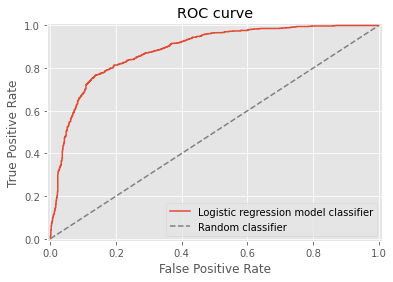

In [127]:
#predict_results = optimizer_means.predict(X_test_z)
predict_proba_results = np.array(list( map(lambda x: int(x>0.5), probabilitiesMean[:,1])))
print ("Predict      :" , predictionsMean[:10])
print ("Predict_proba:", predict_proba_results[:10])
filter(lambda e: e == False , np.equal(predict_proba_results, predictionsMean))
print (roc_auc_score(y_test, predictionsMean))
print (roc_auc_score(y_test, predict_proba_results))
print (roc_auc_score(y_test, probabilitiesMean[:,1]))

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, probabilitiesMean[:,1])
%pylab inline
pylab.plot(fpr, tpr, label = "Logistic regression model classifier")
pylab.plot([0, 1], [0, 1], "--", color = "grey", label = "Random classifier")
pylab.xlim([-0.01, 1.01])
pylab.ylim([-0.01, 1.01])
pylab.xlabel("False Positive Rate")
pylab.ylabel("True Positive Rate")
pylab.title("ROC curve")
pylab.legend(loc = "lower right") 
pylab.rcParams["figure.figsize"] = [10, 10]

In [128]:
from sklearn.metrics import precision_score
#from sklearn.metrics import precision_score
psM = precision_score(y_test, predictionsMean) 
#psM2 = precision_score(y_test, probabilitiesMean[:,1]) 
print("Precision score for dataset with means for missed values.\n", psM)
#print("Precision score (thru probabilities) for dataset with means for missed values 2.\n", psM2)
#print("Precision score for dataset with means for missed values.\n", psM)
ps0 = precision_score(y_test, predictions0) 
print("Precision score for dataset with zeros for missed values.\n", ps0) 

Precision score for dataset with means for missed values.
 0.7967479674796748
Precision score for dataset with zeros for missed values.
 0.7931034482758621


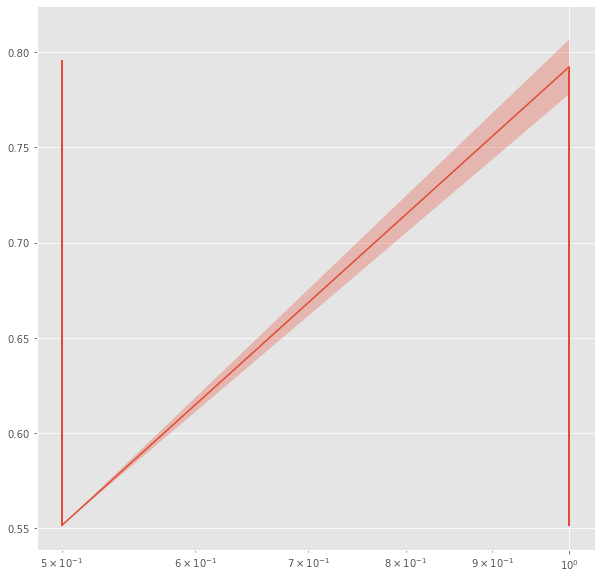

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([ optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

# place your code here
plot_scores(optimizer_means)

4. Получите две метрики качества AUC ROC на тестовой выборке и сравните их между собой. Какой способ заполнения пропущенных вещественных значений работает лучше? В дальнейшем для выполнения задания в качестве вещественных признаков используйте ту выборку, которая даёт лучшее качество на тесте.

In [136]:
auc_mean = roc_auc_score(y_test,  predictionsMean)
print("With mean values for NaN\nAUC score for dataset with means for missed values.\n", auc_mean) 
# probabilitiesMean[:,1]
auc_mean_prob = roc_auc_score(y_test,  probabilitiesMean[:,1])
print("AUC score thru probabilities for dataset with means for missed values.\n", auc_mean_prob) 
auc_0 = roc_auc_score(y_test,  predictions0)
print("-----------------------------\nWith zero values for NaN\nAUC score for dataset with zeros for missed values.\n", auc_0) 
auc_0_prob = roc_auc_score(y_test,  probabilities0[:,1])
print("AUC score thru probabilities for dataset with zeros for missed values.\n", auc_0_prob)

With mean values for NaN
AUC score for dataset with means for missed values.
 0.8074444008607303
AUC score thru probabilities for dataset with means for missed values.
 0.8846669743649392
-----------------------------
With zero values for NaN
AUC score for dataset with zeros for missed values.
 0.8071270096801217
AUC score thru probabilities for dataset with zeros for missed values.
 0.8839554736676685


From here we see that the dataset with means for missed values gives higher AUC ROC compare with one for the dataset with zeros for missed values. 

NOTE: the **AUC score** calculated from probabilities vector (0.88) is higher than **AUC score** calculated from predictions vector (0.81).

5. Передайте два значения AUC ROC (сначала для выборки, заполненной средними, потом для выборки, заполненной нулями) в функцию write_answer_1 и запустите её. Полученный файл является ответом на 1 задание.

Информация для интересующихся: вообще говоря, не вполне логично оптимизировать на кросс-валидации заданный по умолчанию в классе логистической регрессии функционал accuracy, а измерять на тесте AUC ROC, но это, как и ограничение размера выборки, сделано для ускорения работы процесса кросс-валидации.

In [134]:
write_answer_1(auc_mean_prob, auc_0_prob)

## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

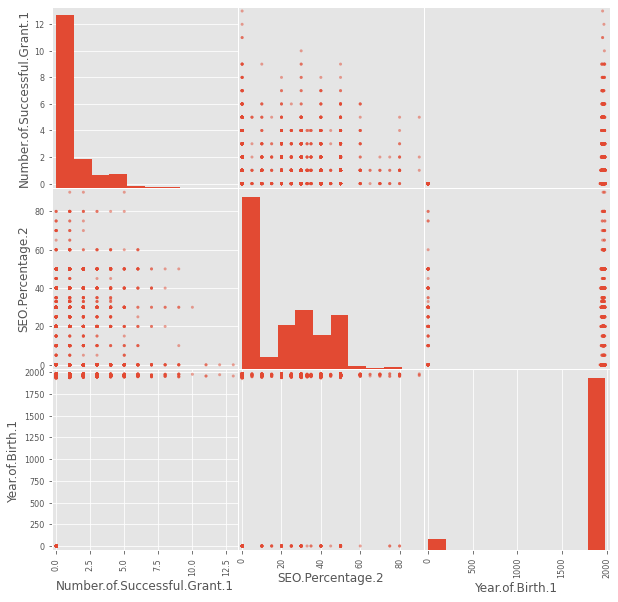

In [138]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, **разные признаки очень сильно отличаются друг от друга по модулю значений** (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но **при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже**.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность (interpretability), потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Задание 1.5. Масштабирование вещественных признаков.

1. По аналогии с вызовом one-hot encoder примените масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)
2. Сохраните ответ в переменные X_train_real_scaled и X_test_real_scaled соответственно

In [152]:
X_train_real_zeros.head(3)

RFCD.Percentage.1  RFCD.Percentage.2  RFCD.Percentage.3  \
4831               30.0               30.0               40.0   
4646               40.0               30.0               30.0   
2154               30.0               40.0               30.0   

      RFCD.Percentage.4  RFCD.Percentage.5  SEO.Percentage.1  \
4831                0.0                0.0              50.0   
4646                0.0                0.0              40.0   
2154                0.0                0.0              50.0   

      SEO.Percentage.2  SEO.Percentage.3  SEO.Percentage.4  SEO.Percentage.5  \
4831              50.0               0.0               0.0               0.0   
4646              60.0               0.0               0.0               0.0   
2154              50.0               0.0               0.0               0.0   

      Year.of.Birth.1  Number.of.Successful.Grant.1  \
4831           1960.0                           0.0   
4646           1970.0                           0.0   
2154           1980.0                           0.0   

      Number.of.Unsuccessful.Grant.1  
4831                             0.0  
4646                             0.0  
2154                             1.0

In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)  
X_test_real_scaled = scaler.fit_transform(X_test_real_zeros)  
#print('Scaled real featues (with zeros):\n', X_train_real_scaled)
#print('------\nScaled real featues with mean:\n', X_train_real_mean_scaled)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

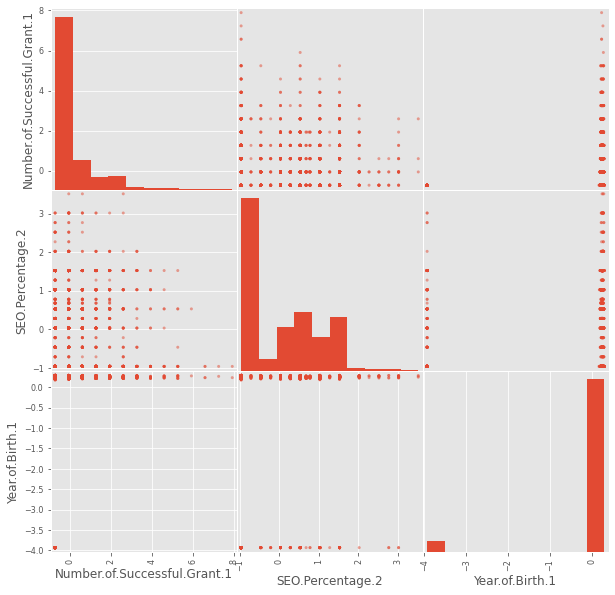

In [173]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

## Задание 2. Сравнение качества классификации до и после масштабирования вещественных признаков.
1. Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверьте, был ли найден оптимум accuracy по гиперпараметрам во время кроссвалидации.
3. Получите значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.
4. Запишите полученный ответ в файл при помощи функции write_answer_2.

In [181]:
estimator2 = linear_model.LogisticRegression(random_state = 0, n_jobs =3,  penalty = "l2", solver='liblinear')  
print('Estimator.get_params():\n', estimator2.get_params())
# params grid
param_grid = {
    "C" : [0.5,  1],
    "intercept_scaling" : [0.001, 0.01, 0,1],
    "tol" : [0.001, 0.05],
}
# set up optimizer with scoring = `accuracy` as the strategy to evaluate the performance
optimizer2 = model_selection.GridSearchCV(estimator2, param_grid, scoring = "accuracy",  cv = 3)

# we join real and categorical features values for scaled
X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh)) 
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))
print('\nX_train_scaled shape:', X_train_scaled.shape) 
print('X_test_scaled shape:', X_test_scaled.shape) 

Estimator.get_params():
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': 3, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

X_train_scaled shape: (4200, 5606)
X_test_scaled shape: (1800, 5606)


In [182]:
# Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
optimizer2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(n_jobs=3, random_state=0,
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1],
                         'intercept_scaling': [0.001, 0.01, 0, 1],
                         'tol': [0.001, 0.05]},
             scoring='accuracy')

In [183]:
N=10
predictions_scaled = optimizer2.predict(X_test_scaled)
probabilities_scaled = optimizer2.predict_proba(X_test_scaled)
#print(probabilities[ 0:N, 1])
print("Optimizer for scaled dataset with zeros for missed values.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test[:N], probabilities_scaled[ 0:N, 1], predictions_scaled[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer for scaled dataset with zeros for missed values.
  Label   Proba     Prediction
   0      0.84     1
   1      0.403     0
   0      0.063     0
   1      0.954     1
   0      0.045     0
   1      0.986     1
   0      0.037     0
   1      0.122     0
   0      0.054     0
   1      0.853     1


In [374]:
# Проверьте, был ли найден оптимум accuracy по гиперпараметрам во время кроссвалидации.
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions_scaled)

0.8127777777777778

In [193]:
optimizer.best_params_

{'C': 0.5, 'intercept_scaling': 0.001, 'tol': 0.001}

In [185]:
auc_scaled = roc_auc_score(y_test,  predictions_scaled)
print("AUC score for scaled dataset with zeros for missed values.\n", auc_scaled) 
auc_scaled_prob = roc_auc_score(y_test,  probabilities_scaled[:,1])
print("AUC score thru probabilities for scaled dataset with zeros for missed values.\n", auc_scaled_prob)

AUC score for scaled dataset with zeros for missed values.
 0.8120567814678198
AUC score thru probabilities for scaled dataset with zeros for missed values.
 0.8864649056921292


In [186]:
def write_answer_2(auc):
    with open("preprocessing_lr_answer2.txt", "w") as fout:
        fout.write(str(auc))
        
write_answer_2(   auc_scaled_prob )

## Балансировка классов.

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Рассмотрим пример с выборками, сэмплированными из двух гауссиан. Их мат. ожидания и матрицы ковариации заданы так, что истинная разделяющая поверхность должна проходить параллельно оси x. Поместим в обучающую выборку 20 объектов, сэмплированных из 1-й гауссианы, и 10 объектов из 2-й. После этого обучим на них линейную регрессию, и построим на графиках объекты и области классификации.

Data 0:
 [[ 1.24737338  0.28295388]
 [ 0.69207227  1.58455078]
 [ 1.32056292 -0.69103982]
 [ 0.67181396 -0.10702571]]


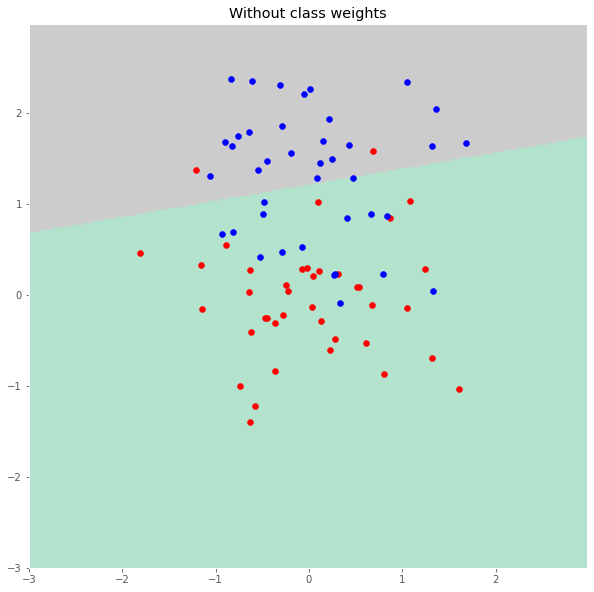

AUC: 0.911667


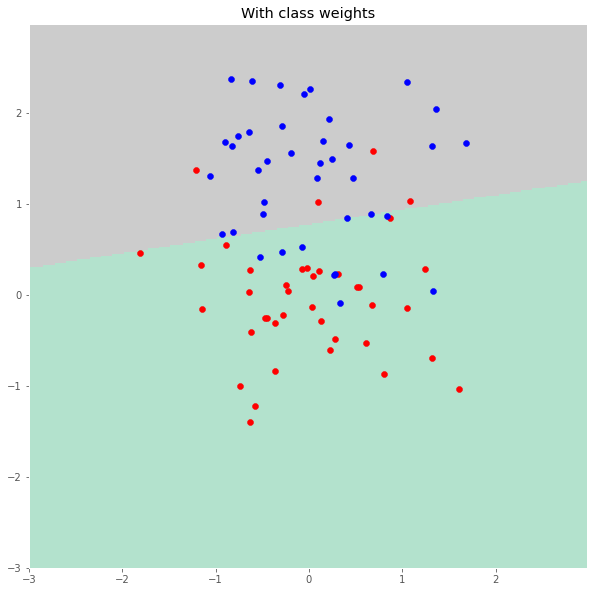

AUC: 0.918333


In [192]:
np.random.seed(0)
"""Сэмплируем данные из первой гауссианы"""
data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=40)
print('Data 0:\n', data_0[0:4, :])
"""И из второй"""
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=40)
"""На обучение берём 20 объектов из первого класса и 10 из второго"""
example_data_train = np.vstack([data_0[:20,:], data_1[:10,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])
"""На тест - 20 из первого и 30 из второго"""
example_data_test = np.vstack([data_0[20:,:], data_1[10:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])
"""Задаём координатную сетку, на которой будем вычислять область классификации"""
xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
"""Обучаем регрессию без балансировки по классам"""
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
"""Строим предсказания регрессии для сетки"""
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
"""Считаем AUC"""
auc_wo_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('Without class weights')
plt.show()
print('AUC: %f'%auc_wo_class_weights)
"""Для второй регрессии в LogisticRegression передаём параметр class_weight='balanced'"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_w_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC: %f'%auc_w_class_weights)

Как видно, во втором случае классификатор находит разделяющую поверхность, которая ближе к истинной, т.е. меньше переобучается. Поэтому на сбалансированность классов в обучающей выборке всегда следует обращать внимание.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [269]:
print('Total train size:', y_train.shape[0])
print(np.sum(y_train==0) , ',', round(np.sum(y_train==0)/y_train.shape[0], 2), '% of train size.')
print(np.sum(y_train==1) , ',', round(np.sum(y_train==1)/y_train.shape[0], 2), '% of train size.')

Total train size: 4200
2316 , 0.55 % of train size.
1884 , 0.45 % of train size.


Видно, что нет.

Исправить ситуацию можно разными способами, мы рассмотрим два:
- давать объектам миноритарного класса больший вес при обучении классификатора (рассмотрен в примере выше)
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется

## Задание 3. Балансировка классов.
1. Обучите логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убедитесь, что вы нашли максимум accuracy по гиперпараметрам.
2. Получите метрику ROC AUC на тестовой выборке.
3. Сбалансируйте выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используйте следующую комбинацию вызовов функций:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
   После этого добавьте эти объекты в начало или конец обучающей выборки. Дополните соответствующим      образом вектор ответов.
4. Получите метрику ROC AUC на тестовой выборке, сравните с предыдущим результатом.
5. Внесите ответы в выходной файл при помощи функции write_asnwer_3, передав в неё сначала ROC AUC для балансировки весами, а потом балансировки выборки вручную.

1. Обучите логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убедитесь, что вы нашли максимум accuracy по гиперпараметрам.

In [232]:
optimizer3 = GridSearchCV(LogisticRegression(class_weight='balanced', penalty = "l2", solver='liblinear'), 
                     param_grid, cv=cv,  scoring = "accuracy")
optimizer3.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1],
                         'intercept_scaling': [0.001, 0.01, 0, 1],
                         'tol': [0.001, 0.05]},
             scoring='accuracy')

In [233]:
predictions_scaled_balanced = optimizer3.predict(X_test_scaled)
probabilities_scaled_balanced = optimizer3.predict_proba(X_test_scaled)
#print(probabilities[ 0:N, 1])
print("Optimizer 3 for scaled dataset with class balancing.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test[:N], probabilities_scaled_balanced[ 0:N, 1], predictions_scaled_balanced[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))
    

Optimizer 3 for scaled dataset with class balancing.
  Label   Proba     Prediction
   0      0.862     1
   1      0.449     0
   0      0.075     0
   1      0.96     1
   0      0.055     0
   1      0.988     1
   0      0.045     0
   1      0.139     0
   0      0.065     0
   1      0.869     1


In [253]:
print("\nAccuracy for the balanced classes on test:", accuracy_score(y_test, predictions_scaled_balanced))
print('\nOptimizer best_score_:', optimizer3.best_score_)
print('\nOptimizer best_params_:', optimizer3.best_params_) 
print('\nTest scores (accuracy):\n----------------------')
score_common = []
for split in ['split0_test_score', 'split1_test_score', 'split2_test_score' ]:
    for a in optimizer3.cv_results_[split]:
        if ~np.isnan(a):
            print(a) 
            score_common.append(a)


Accuracy for the balanced classes on test: 0.8094444444444444

Optimizer best_score_: 0.7869047619047619

Optimizer best_params_: {'C': 0.5, 'intercept_scaling': 0.001, 'tol': 0.001}

Test scores (accuracy):
----------------------
0.7828571428571428
0.7807142857142857
0.7828571428571428
0.7814285714285715
0.7828571428571428
0.7807142857142857
0.7757142857142857
0.775
0.7757142857142857
0.775
0.7757142857142857
0.7757142857142857
0.8057142857142857
0.805
0.8057142857142857
0.805
0.8057142857142857
0.805
0.8035714285714286
0.8
0.8035714285714286
0.8
0.8035714285714286
0.8
0.7721428571428571
0.7714285714285715
0.7721428571428571
0.7714285714285715
0.7721428571428571
0.7714285714285715
0.7728571428571429
0.7714285714285715
0.7728571428571429
0.7714285714285715
0.7728571428571429
0.7714285714285715


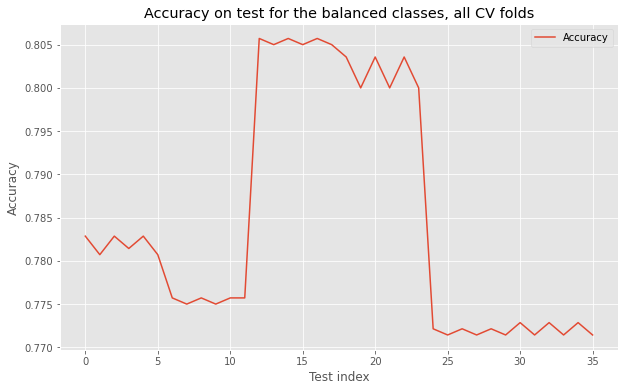

In [255]:
# we remove nan
#score_no_nan0 = optimizer3.cv_results_['split0_test_score'][~np.isnan( optimizer3.cv_results_['split0_test_score'])]
#score_no_nan1 = optimizer3.cv_results_['split1_test_score'][~np.isnan( optimizer3.cv_results_['split1_test_score'])]
#score_no_nan2 = optimizer3.cv_results_['split2_test_score'][~np.isnan( optimizer3.cv_results_['split2_test_score'])]

# join 3 numpy arrays
#score_common = np.concatenate(( score_no_nan0 , score_no_nan1 , score_no_nan2 )) 

# plot all possible parameters
pylab.plot(np.arange(0, len(score_common)), score_common,  label = "Accuracy")
pylab.xlabel("Test index")
pylab.ylabel("Accuracy")
pylab.title("Accuracy on test for the balanced classes, all CV folds")
pylab.legend(loc = 'best') 
pylab.rcParams["figure.figsize"] = [10, 6]

2. Получите метрику ROC AUC на тестовой выборке.

In [257]:
auc_scaled_balanced = roc_auc_score(y_test,  predictions_scaled_balanced)
print("AUC score for scaled dataset with the balanced classes.\n", auc_scaled_balanced) 
auc_scaled_prob_balanced = roc_auc_score(y_test,  probabilities_scaled_balanced[:,1])
print("AUC score thru probabilities for scaled dataset with the balanced classes.\n", auc_scaled_prob_balanced)

AUC score for scaled dataset with the balanced classes.
 0.8096735634800922
AUC score thru probabilities for scaled dataset with the balanced classes.
 0.8866183423642364


3. Сбалансируйте выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используйте следующую комбинацию вызовов функций:

 np.random.seed(0)
 
 indices_to_add = np.random.randint(...)
 
 X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]

После этого добавьте эти объекты в начало или конец обучающей выборки. Дополните соответствующим образом вектор ответов.

In [270]:
print('Total train size:', y_train.shape[0])
print(np.sum(y_train==0) , ',', round(np.sum(y_train==0)/y_train.shape[0], 2), '% of train size.')
print(np.sum(y_train==1) , ',', round(np.sum(y_train==1)/y_train.shape[0], 2), '% of train size.')

Total train size: 4200
2316 , 0.55 % of train size.
1884 , 0.45 % of train size.


In [280]:
"""np.random.seed(0)\n",
    "number_to_add = np.sum(y_train == 0) - np.sum(y_train == 1)\n",
    "indices_to_add = np.random.randint(np.sum(y_train == 1), size = number_to_add)\n",
    "X_train_to_add = X_train_scaled[y_train.as_matrix() == 1,:][indices_to_add,:]"""

np.random.seed(0)
number_to_add = np.sum(y_train == 0) - np.sum(y_train == 1)
#indices_to_add = np.random.randint(...)
print('Size to add', number_to_add )
indices_to_add = np.random.randint(np.sum(y_train == 1), size = number_to_add)
print('The train set indices to add\n',  indices_to_add)
X_train_to_add = X_train_scaled[y_train  == 1,:][indices_to_add,:]


Size to add 432
The train set indices to add
 [ 684  559 1653 1216  835  763 1731 1383 1033 1747  277 1778 1828  599
 1094 1496  600 1420  314  705 1510  551   87  174 1624  849 1701  537
  845   72  777  115  976  755 1733 1871 1455  448  850   99 1201  755
  797  659 1171  910  423 1312 1289  697  639  544  543  714  244  151
  675  510 1483  882 1207   28  802  128  128 1077 1574 1512  756  273
  335  388 1641 1066 1466  543  888  257 1345   57  291 1143  779  430
 1106   91  398  611 1589  908  633   84  203  324  774  964 1071  639
 1155  972  868 1204 1870 1167 1684 1251  954  791  719  909  373 1877
  560 1329 1605  169 1699 1472 1119 1221 1630  256 1714 1316  816  387
 1634 1578  973  368  917  201  383 1536  370  555  954 1407   23 1723
  130  377   98 1598  931  734  123  594  739 1172  209  562 1435  782
 1065 1082  705 1060  778   86 1067  872   11  770  307 1104   32 1206
 1152  806  275 1198 1578 1395 1208  444  488 1613  286 1304  637  770
 1539   94 1250 1293  296 1352 

In [277]:
X_train_to_add.shape, X_train_to_add

((432, 5606),
 array([[-1.54878241,  1.75530144,  2.05951874, ...,  0.        ,
          0.        ,  1.        ],
        [-0.92703114,  0.71379291,  2.05951874, ...,  0.        ,
          1.        ,  0.        ],
        [ 0.3164714 , -0.32771562,  0.31671338, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.92703114,  0.19303865,  2.93092143, ...,  0.        ,
          1.        ,  0.        ],
        [ 0.93822266, -0.84846988, -0.5546893 , ...,  0.        ,
          0.        ,  1.        ],
        [ 0.93822266, -0.84846988, -0.5546893 , ...,  0.        ,
          1.        ,  0.        ]]))

In [283]:
X_train_sample = np.vstack([X_train_scaled, X_train_to_add])
y_train_sample = np.concatenate((y_train, np.ones(number_to_add)))
print('Total X train size upsampled:', X_train_sample.shape)
print('Total y train size upsampled:', y_train_sample.shape)

Total X train size upsampled: (4632, 5606)
Total y train size upsampled: (4632,)


4. Получите метрику ROC AUC на тестовой выборке, сравните с предыдущим результатом.
5. Внесите ответы в выходной файл при помощи функции write_asnwer_3, передав в неё сначала ROC AUC для балансировки весами, а потом балансировки выборки вручную.

In [285]:
optimizer4 = GridSearchCV(LogisticRegression( penalty = "l2", solver='liblinear'), 
                     param_grid, cv=cv,  scoring = "accuracy")
optimizer4.fit(X_train_sample, y_train_sample)

GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='accuracy')

In [286]:
predictions_scaled_sampled = optimizer4.predict(X_test_scaled)
probabilities_scaled_sampled = optimizer4.predict_proba(X_test_scaled)
#print(probabilities[ 0:N, 1])
print("Optimizer 3 for scaled dataset with class balancing.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test[:N], probabilities_scaled_sampled[ 0:N, 1], predictions_scaled_sampled[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer 3 for scaled dataset with class balancing.
  Label   Proba     Prediction
   0      0.878     1
   1      0.436     0
   0      0.071     0
   1      0.966     1
   0      0.054     0
   1      0.997     1
   0      0.08     0
   1      0.198     0
   0      0.056     0
   1      0.886     1


In [287]:
auc_scaled_sampled = roc_auc_score(y_test,  predictions_scaled_sampled)
print("AUC score for scaled dataset with the balanced classes.\n", auc_scaled_balanced) 
auc_scaled_prob_sampled = roc_auc_score(y_test,  probabilities_scaled_sampled[:,1])
print("AUC score thru probabilities for scaled dataset with the balanced classes.\n", auc_scaled_prob_balanced)

AUC score for scaled dataset with the balanced classes.
 0.8096735634800922
AUC score thru probabilities for scaled dataset with the balanced classes.
 0.8866183423642364


In [288]:
def write_answer_3(auc_1, auc_2):
    auc = (auc_1 + auc_2) / 2
    with open("preprocessing_lr_answer3.txt", "w") as fout:
        fout.write(str(auc))
        
# place your code here
write_answer_3(auc_scaled_prob_balanced, auc_scaled_prob_balanced)

## Стратификация выборок.

Рассмотрим ещё раз пример с выборками из нормальных распределений. Посмотрим ещё раз на качество классификаторов, получаемое на тестовых выборках:

In [289]:
print('AUC ROC for classifier without weighted classes', auc_wo_class_weights)
print('AUC ROC for classifier with weighted classes: ', auc_w_class_weights)

AUC ROC for classifier without weighted classes 0.9116666666666666
AUC ROC for classifier with weighted classes:  0.9183333333333333


Насколько эти цифры реально отражают качество работы алгоритма, если учесть, что тестовая выборка так же несбалансирована, как обучающая? При этом мы уже знаем, что алгоритм логистический регрессии чувствителен к балансировке классов в обучающей выборке, т.е. в данном случае на тесте он будет давать заведомо заниженные результаты. Метрика классификатора на тесте имела бы гораздо больший смысл, если бы объекты были разделы в выборках поровну: по 20 из каждого класса на обучени и на тесте. Переформируем выборки и подсчитаем новые ошибки:

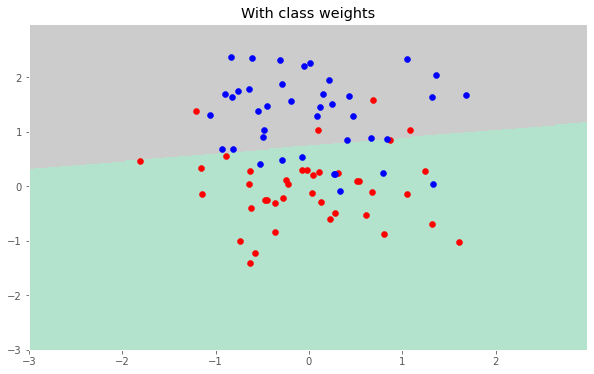

AUC ROC for stratified samples:  0.9125


In [290]:
"""Разделим данные по классам поровну между обучающей и тестовой выборками"""
example_data_train = np.vstack([data_0[:20,:], data_1[:20,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:,:], data_1[20:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])
"""Обучим классификатор"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_stratified = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC ROC for stratified samples: ', auc_stratified)

Как видно, после данной процедуры ответ классификатора изменился незначительно, а вот качество увеличилось. При этом, в зависимости от того, как вы разбили изначально данные на обучение и тест, после сбалансированного разделения выборок итоговая метрика на тесте может как увеличиться, так и уменьшиться, но доверять ей можно значительно больше, т.к. она построена с учётом специфики работы классификатора. Данный подход является частным случаем т.н. метода стратификации.

## Задание 4. Стратификация выборки.

1. По аналогии с тем, как это было сделано в начале задания, разбейте выборки X_real_zeros и X_cat_oh на обучение и тест, передавая в функцию 
        train_test_split(...)
   дополнительно параметр 
       stratify=y
   Также обязательно передайте в функцию переменную random_state=0.
   

In [292]:
(X_train_real_statify, 
 X_test_real_statify, 
 y_train_statify, y_test_statify) = train_test_split(X_real_zeros, y, stratify=y,
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_statify,
 X_test_cat_oh_statify) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

2. Выполните масштабирование новых вещественных выборок, обучите классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов. Убедитесь в том, что нашли оптимум accuracy по гиперпараметрам.

In [293]:
scaler2 = StandardScaler() 
X_train_real_statify_scaled = scaler2.fit_transform(X_train_real_statify)  
X_test_real_statify_scaled = scaler2.fit_transform(X_test_real_statify) 

In [294]:
# we join real and categorical features values for scaled
X_train_statify_scaled = np.hstack((X_train_real_statify_scaled, X_train_cat_oh_statify)) 
X_test_statify_scaled = np.hstack((X_test_real_statify_scaled, X_test_cat_oh_statify))
print('\nX_train_statify_scaled shape:', X_train_statify_scaled.shape) 
print('X_test_statify_scaled shape:', X_test_statify_scaled.shape) 


X_train_statify_scaled shape: (4200, 5606)
X_test_statify_scaled shape: (1800, 5606)


In [295]:
optimizer5 = GridSearchCV(LogisticRegression(class_weight='balanced', penalty = "l2", solver='liblinear'), 
                     param_grid, cv=cv,  scoring = "accuracy")
optimizer5.fit(X_train_statify_scaled , y_train_statify)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='accuracy')

In [298]:
predictions_statify_scaled = optimizer5.predict(X_test_statify_scaled)
probabilities_statify_scaled = optimizer5.predict_proba(X_test_statify_scaled)
#print(probabilities[ 0:N, 1])
print("Optimizer 5 for scaled, stratified dataset with class weights balancing.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test_statify[:N], probabilities_statify_scaled[ 0:N, 1], predictions_statify_scaled[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer 5 for scaled, stratified dataset with class weights balancing.
  Label   Proba     Prediction
   0      0.052     0
   0      0.298     0
   0      0.097     0
   0      0.161     0
   0      0.652     1
   0      0.361     0
   1      0.915     1
   0      0.331     0
   1      0.651     1
   0      0.153     0


3. Оцените качество классификатора метрике AUC ROC на тестовой выборке.

In [299]:
auc_statify_scaled = roc_auc_score(y_test_statify,  predictions_statify_scaled)
print("AUC score for scaled, stratified dataset with class weights balancing.\n", auc_statify_scaled) 
auc_prob_statify_scaled = roc_auc_score(y_test_statify,  probabilities_statify_scaled[:,1])
print("AUC score thru probabilities for scaled, stratified dataset with class weights balancing.\n", auc_prob_statify_scaled)

AUC score for scaled, stratified dataset with class weights balancing.
 0.7885973161375068
AUC score thru probabilities for scaled, stratified dataset with class weights balancing.
 0.8794071768692251


4. Полученный ответ передайте функции write_answer_4

In [300]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        
# place your code here
write_answer_4(auc_prob_statify_scaled)

Теперь вы разобрались с основными этапами предобработки данных для линейных классификаторов.
Напомним основные этапы:
- обработка пропущенных значений
- обработка категориальных признаков
- стратификация
- балансировка классов
- масштабирование

Данные действия с данными рекомендуется проводить всякий раз, когда вы планируете использовать линейные методы. Рекомендация по выполнению многих из этих пунктов справедлива и для других методов машинного обучения.

## Трансформация признаков.

Теперь рассмотрим способы преобразования признаков. Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Рассмотрим принцип работы данных признаков на данных, сэмплированных их гауссиан:

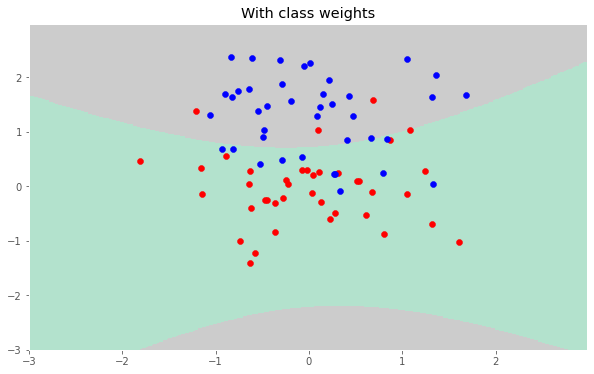

In [301]:
from sklearn.preprocessing import PolynomialFeatures

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2)
"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
"""Обращаем внимание на параметр fit_intercept=False"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('With class weights')
plt.show()

Видно, что данный метод преобразования данных уже позволяет строить нелинейные разделяющие поверхности, которые могут более тонко подстраиваться под данные и находить более сложные зависимости. Число признаков в новой модели:

In [302]:
print(example_data_train_poly.shape)

(40, 6)


Но при этом одновременно данный метод способствует более сильной способности модели к переобучению из-за быстрого роста числа признаком с увеличением степени $p$. Рассмотрим пример с $p=11$:

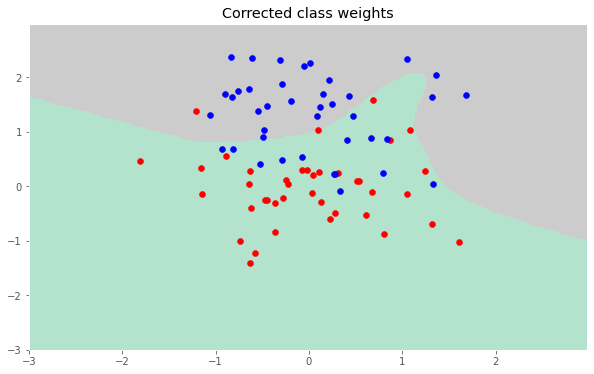

In [303]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('Corrected class weights')
plt.show()

Количество признаков в данной модели:

In [304]:
print(example_data_train_poly.shape)

(40, 78)


## Задание 5. Трансформация вещественных признаков.

1. Реализуйте по аналогии с примером преобразование вещественных признаков модели при помощи полиномиальных признаков степени 2.
2. Постройте логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Обращаем внимание, что в преобразованных признаках уже присутствует столбец, все значения которого равны 1, поэтому обучать дополнительно значение $b$ не нужно, его функцию выполняет один из весов $w$. В связи с этим во избежание линейной зависимости в датасете, в вызов класса логистической регрессии требуется передавать параметр fit_intercept=False. Для обучения используйте стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.
3. Получите AUC ROC на тесте и сравните данный результат с использованием обычных признаков.
4. Передайте полученный ответ в функцию write_answer_5.

1. Реализуйте по аналогии с примером **преобразование вещественных признаков модели** при помощи полиномиальных признаков степени 2

In [342]:
transform = PolynomialFeatures(2)
X_real_poly = transform.fit_transform(X_real_zeros) 
print(X_train_real_zeros.shape) # 4200, 13
print(X_real_poly.shape) # 4200, 105 

(4200, 13)
(6000, 105)


2. Постройте логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Обращаем внимание, что в преобразованных признаках уже присутствует столбец, все значения которого равны 1, поэтому обучать дополнительно значение $b$ не нужно, его функцию выполняет один из весов $w$. В связи с этим во избежание линейной зависимости в датасете, в вызов класса логистической регрессии требуется передавать параметр fit_intercept=False. Для обучения используйте стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.

In [329]:
(X_train_real_stratify_poly, 
 X_test_real_stratify_poly, 
 y_train_stratify, y_test_stratify) = train_test_split(X_real_poly, y, stratify=y,
                                     test_size=0.3, 
                                     random_state=0)

In [331]:
scaler3 = StandardScaler() 
X_train_real_stratify_scaled_poly = scaler3.fit_transform(X_train_real_stratify_poly)  
X_test_real_stratify_scaled_poly = scaler3.fit_transform(X_test_real_stratify_poly) 
print('\nX_train_real_stratify_scaled_poly shape:', X_train_real_stratify_scaled_poly.shape) 
print('X_test_real_stratify_scaled_poly shape:', X_test_real_stratify_scaled_poly.shape)


X_train_real_stratify_scaled_poly shape: (4200, 105)
X_test_real_stratify_scaled_poly shape: (1800, 105)


In [332]:
# we join real and categorical features values for scaled
X_train_stratify_scaled_poly = np.hstack((X_train_real_stratify_scaled_poly, X_train_cat_oh_statify)) 
X_test_stratify_scaled_poly = np.hstack((X_test_real_stratify_scaled_poly, X_test_cat_oh_statify))
print('\nX_train_stratify_scaled_poly shape:', X_train_stratify_scaled_poly.shape) 
print('X_test_stratify_scaled_poly shape:', X_test_stratify_scaled_poly.shape) 


X_train_stratify_scaled_poly shape: (4200, 5698)
X_test_stratify_scaled_poly shape: (1800, 5698)


In [334]:
param_grid = {
    "C" : [0.5,  1],
    "intercept_scaling" : [0.001, 0.01, 0,1],
    "tol" : [0.001, 0.05],
}
optimizer6 = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer6.fit(X_train_stratify_scaled_poly, y_train_statify)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          fit_intercept=False),
             n_jobs=-1,
             param_grid={'C': [0.5, 1],
                         'intercept_scaling': [0.001, 0.01, 0, 1],
                         'tol': [0.001, 0.05]})

3. Получите AUC ROC на тесте и сравните данный результат с использованием обычных признаков.

In [335]:
predictions_scaled_poly = optimizer6.predict(X_test_stratify_scaled_poly )
probabilities_scaled_poly = optimizer6.predict_proba(X_test_stratify_scaled_poly )
#print(probabilities[ 0:N, 1])
print("Optimizer 3 for scaled dataset with class balancing.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test_statify[:N], probabilities_scaled_poly[ 0:N, 1], predictions_scaled_poly[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer 3 for scaled dataset with class balancing.
  Label   Proba     Prediction
   0      0.005     0
   0      0.17     0
   0      0.043     0
   0      0.127     0
   0      0.249     0
   0      0.357     0
   1      0.955     1
   0      0.23     0
   1      0.662     1
   0      0.166     0


In [336]:
auc_stratify_scaled_poly = roc_auc_score(y_test_stratify,  predictions_scaled_poly)
print("Polymial model\n----------------------------\nAUC score for scaled, stratified dataset with class weights balancing.\n", auc_stratify_scaled_poly) 
auc_prob_stratify_scaled_poly = roc_auc_score(y_test_stratify,  probabilities_scaled_poly[:,1])
print("AUC score thru probabilities for scaled, stratified dataset with class weights balancing.\n", auc_prob_stratify_scaled_poly)

Polymial model
----------------------------
AUC score for scaled, stratified dataset with class weights balancing.
 0.8046400370187932
AUC score thru probabilities for scaled, stratified dataset with class weights balancing.
 0.886749983829156


In [337]:
def write_answer_5(auc):
    with open("preprocessing_lr_answer5.txt", "w") as fout:
        fout.write(str(auc))
        
# place your code here
write_answer_5(auc_prob_stratify_scaled_poly)

## Регрессия Lasso.
К логистической регрессии также можно применить L1-регуляризацию (Lasso), вместо регуляризации L2, которая будет приводить к отбору признаков. Вам предлагается применить L1-регуляцию к исходным признакам и **проинтерпретировать полученные результаты** (применение отбора признаков к полиномиальным так же можно успешно применять, но в нём уже будет отсутствовать компонента интерпретации, т.к. смысловое значение оригинальных признаков известно, а полиномиальных - уже может быть достаточно нетривиально). Для вызова логистической регрессии с L1-регуляризацией достаточно передать параметр penalty='l1' в инициализацию класса.

## Задание 6. Отбор признаков при помощи регрессии Lasso.
1. Обучите регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов. Для задания используем X_train_real_zeros.

In [338]:
X_train_real_zeros.shape

(4200, 13)

In [339]:
X_real_zeros.shape

(6000, 13)

In [340]:
# we split real and categorial one-hot transformed features
(X_train_real_stratify, 
 X_test_real_stratify, 
 y_train_stratify, y_test_stratify) = train_test_split(X_real_zeros, y, stratify=y,
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_stratify,
 X_test_cat_oh_stratify) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

In [345]:
# we scale real features
scaler4 = StandardScaler() 
X_train_real_stratify_scaled = scaler4.fit_transform(X_train_real_stratify)  
X_test_real_stratify_scaled = scaler4.fit_transform(X_test_real_stratify) 
print('\nX_train_real_statify_scaled  shape:', X_train_real_stratify_scaled.shape) 
print('X_test_real_statify_scaled  shape:', X_test_real_stratify_scaled.shape)


X_train_real_statify_scaled  shape: (4200, 13)
X_test_real_statify_scaled  shape: (1800, 13)


In [366]:
# we join real and categorical features values for scaled
X_train_stratify_scaled  = np.hstack((X_train_real_statify_scaled , X_train_cat_oh_statify)) 
X_test_stratify_scaled  = np.hstack((X_test_real_statify_scaled , X_test_cat_oh_statify))
print('\nX_train_stratify_scaled  shape:', X_train_stratify_scaled.shape) 
print('X_test_stratify_scaled shape:', X_test_stratify_scaled.shape)
print(type(X_train_stratify_scaled))


X_train_stratify_scaled  shape: (4200, 5606)
X_test_stratify_scaled shape: (1800, 5606)
<class 'numpy.ndarray'>


In [353]:
lasso = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
lasso.fit(X_train_statify_scaled , y_train_stratify)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [350]:
optimizer7 = GridSearchCV(lasso, param_grid, cv=cv, n_jobs=-1)
optimizer7.fit(X_train_statify_scaled , y_train_stratify)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.5, 1],
                         'intercept_scaling': [0.001, 0.01, 0, 1],
                         'tol': [0.001, 0.05]})

2. Получите ROC AUC регрессии, сравните его с предыдущими результатами.

In [363]:
for y in lasso.coef_:
    for i in range(len( y)):
        print(i, y[i])

0 0.00973849662516581
1 0.04010090302985703
2 -0.08910574281571239
3 -0.06792700816783176
4 0.0
5 -0.005567892628053955
6 0.0
7 0.0
8 0.02682220524052821
9 -0.007227253041068285
10 0.23215722633747224
11 1.0651368132964876
12 -1.4337944256699215
13 -0.048168357136677525
14 0.0
15 -0.1868922544667287
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.2626108046684127
23 0.18939717771612188
24 0.12851268812460812
25 -0.35951293941023094
26 0.0
27 0.6363808922289712
28 0.3212506538338019
29 0.0
30 -0.30517736794254885
31 0.0
32 -1.715569880540827
33 0.0
34 1.7124377890021705
35 0.4744370496279145
36 0.0
37 -0.1612679412149857
38 0.0
39 -0.13100065306038386
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 -0.20308603392266114
50 0.0
51 0.0
52 0.1826324070289328
53 2.2182228043105927
54 0.0
55 0.09593163470608886
56 0.0
57 0.0
58 0.0
59 0.35591295099795367
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 -0.4407215177980185
66 -0.008922262287612613
67 0.0
68 0.0
69 0.0
70 0.0
71 -0.258829

732 0.0
733 0.0
734 0.0
735 0.0
736 0.0
737 0.0
738 0.0
739 0.0
740 0.0
741 0.0
742 0.0
743 0.0
744 0.0
745 0.0
746 0.0
747 0.0
748 0.0
749 0.0
750 0.0
751 0.0
752 0.0
753 0.0
754 0.0
755 0.0
756 0.0
757 0.0
758 0.0
759 0.0
760 0.0
761 3.0783380138834757
762 0.0
763 0.0
764 0.05199623438029751
765 0.0
766 0.0
767 0.0
768 0.0
769 0.0
770 0.0
771 0.0
772 0.0
773 0.0
774 0.0
775 0.0
776 0.0
777 0.0
778 0.0
779 0.0
780 0.0
781 0.0
782 0.0
783 0.0
784 0.0
785 0.0
786 0.0
787 0.0
788 0.0
789 0.0
790 0.0
791 0.0
792 0.0
793 0.0
794 0.0
795 0.0
796 0.0
797 0.4791218872977283
798 0.032430787608242036
799 0.0
800 0.0
801 -0.4084728848152832
802 0.0
803 0.0
804 0.0
805 0.0
806 0.0
807 0.42944578779364756
808 0.0
809 0.0
810 0.0
811 0.0
812 0.0
813 0.0
814 -1.580951963524914
815 0.0
816 0.0
817 0.0
818 0.0
819 0.0
820 0.0
821 0.0
822 0.0
823 0.0
824 0.0
825 0.0
826 0.0
827 0.0
828 0.0
829 0.0
830 0.0
831 0.0
832 0.0
833 0.0
834 0.0
835 0.0
836 0.0
837 0.0
838 0.0
839 0.0
840 0.0
841 0.0
842 0.0
84

1985 0.0
1986 0.0
1987 0.0
1988 0.0
1989 0.0
1990 0.0
1991 0.0
1992 0.0
1993 0.0
1994 -0.5304057116127906
1995 0.0
1996 0.0
1997 0.0
1998 0.0
1999 0.0
2000 0.0
2001 0.0
2002 0.0
2003 0.0
2004 0.0
2005 0.0
2006 0.0
2007 0.0
2008 0.12727345738519946
2009 -0.21944084467445066
2010 0.0
2011 0.0
2012 0.0
2013 0.0
2014 0.0
2015 0.0
2016 0.700750984151459
2017 0.0
2018 0.0
2019 0.0
2020 0.0
2021 0.0
2022 0.0
2023 0.0
2024 0.0
2025 0.0
2026 0.0
2027 0.0
2028 0.0
2029 0.0
2030 0.0
2031 0.0
2032 0.0
2033 0.0
2034 0.0
2035 0.0
2036 0.0
2037 0.0
2038 0.0
2039 0.0
2040 0.0
2041 0.0
2042 0.0
2043 0.0
2044 0.0
2045 0.0
2046 0.0
2047 0.0
2048 0.0
2049 0.0
2050 0.0
2051 0.0
2052 0.0
2053 0.0
2054 0.0
2055 0.0
2056 0.0
2057 0.0
2058 0.0
2059 0.0
2060 0.0
2061 0.0
2062 0.0
2063 0.0
2064 0.0
2065 0.0
2066 0.0
2067 0.0
2068 0.0
2069 0.0
2070 0.0
2071 0.0
2072 0.0
2073 0.0
2074 0.0
2075 0.0
2076 0.0
2077 0.0
2078 0.0
2079 0.0
2080 0.0
2081 0.0
2082 0.0
2083 -0.7134821951951619
2084 0.0
2085 0.0
2086 0.0
208

2984 0.0
2985 0.0
2986 0.0
2987 0.0
2988 0.0
2989 0.0
2990 0.0
2991 0.0
2992 0.0
2993 0.0
2994 1.3390888057375698
2995 0.0
2996 0.0843591066889889
2997 0.0
2998 0.0
2999 0.0
3000 0.0
3001 0.0
3002 0.0
3003 0.02432502935014315
3004 0.0
3005 0.0
3006 0.0
3007 0.0
3008 0.0
3009 0.0
3010 0.0
3011 0.0
3012 0.0
3013 0.0
3014 0.0
3015 0.0
3016 0.0
3017 0.0
3018 0.0
3019 0.0
3020 0.0
3021 0.0
3022 -0.8310888254470856
3023 0.0
3024 0.0
3025 0.0
3026 -1.3953161501374243
3027 0.0
3028 0.0
3029 0.0
3030 0.0
3031 0.0
3032 0.0
3033 0.0
3034 0.0162634987052782
3035 0.0
3036 0.0
3037 0.0
3038 0.16699692533233965
3039 0.0
3040 0.0
3041 0.0
3042 0.0
3043 0.0
3044 0.0
3045 0.0
3046 0.0
3047 0.0
3048 -0.15811823205451897
3049 0.0
3050 0.0
3051 0.0
3052 0.0
3053 0.0
3054 0.0
3055 0.0
3056 0.0
3057 0.0
3058 0.0
3059 0.0
3060 0.0
3061 0.0
3062 0.0
3063 0.0
3064 -2.3431595418574704
3065 0.0
3066 0.0
3067 0.0
3068 0.0
3069 0.0
3070 0.0
3071 0.0
3072 0.0
3073 0.0
3074 0.0
3075 0.0
3076 0.0
3077 0.0
3078 0.0
307

3794 0.0
3795 0.0
3796 0.0
3797 0.0
3798 0.0
3799 0.0
3800 0.0
3801 0.0
3802 0.0
3803 0.0
3804 0.0
3805 0.0
3806 0.0
3807 0.0
3808 0.0
3809 0.0
3810 0.0
3811 0.0
3812 0.0
3813 0.0
3814 0.0
3815 0.0
3816 0.0
3817 0.0
3818 0.0
3819 0.0
3820 0.0
3821 0.0
3822 0.0
3823 0.0
3824 0.0
3825 0.0
3826 0.0
3827 0.0
3828 0.0
3829 0.0
3830 0.0
3831 0.0
3832 0.0
3833 0.0
3834 0.0
3835 0.0
3836 0.0
3837 0.0
3838 0.0
3839 0.0
3840 0.0
3841 0.0
3842 0.0
3843 0.0
3844 0.0
3845 0.0
3846 0.0
3847 0.0
3848 0.0
3849 0.0
3850 0.0
3851 -1.057844692388076
3852 0.0
3853 0.0
3854 0.0
3855 0.0
3856 0.0
3857 0.44786066531741414
3858 0.0
3859 0.0
3860 0.0
3861 0.0
3862 0.0
3863 0.0
3864 0.0
3865 0.0
3866 0.0
3867 0.0
3868 0.0
3869 0.0
3870 0.0
3871 0.5246687833422875
3872 0.0
3873 0.0
3874 0.0
3875 0.0
3876 0.0
3877 0.0
3878 0.0
3879 0.0
3880 0.0
3881 0.0
3882 0.0
3883 0.0
3884 0.0
3885 0.0
3886 0.0
3887 0.0
3888 0.0
3889 0.0
3890 0.0
3891 0.0
3892 0.16766830334308383
3893 0.0
3894 0.0
3895 0.0
3896 -0.246639009664

4733 0.0
4734 0.0
4735 0.0
4736 0.0
4737 0.0
4738 0.0
4739 0.0
4740 0.0
4741 0.0
4742 0.0
4743 0.0
4744 0.0
4745 0.0
4746 0.0
4747 0.0
4748 0.0
4749 0.0
4750 0.0
4751 0.0
4752 0.0
4753 0.0
4754 0.0
4755 0.0
4756 0.0
4757 0.0
4758 0.0
4759 0.0
4760 0.48653067834307184
4761 0.0
4762 0.0
4763 0.2838425232225834
4764 0.0
4765 -0.030913140290143526
4766 0.02219993272198161
4767 0.0
4768 0.8282355592493073
4769 0.0
4770 -0.1413636726161584
4771 0.0
4772 0.0
4773 0.6402220209631054
4774 1.649028839968881
4775 0.0
4776 0.0
4777 -0.04168933000037705
4778 -2.3789568241798356
4779 0.0
4780 0.06601152969486877
4781 0.0
4782 0.0
4783 0.25490899777224596
4784 0.0
4785 0.0
4786 0.0
4787 0.0
4788 0.0
4789 0.0
4790 0.0
4791 0.5685062093887724
4792 0.0
4793 -0.14868837101655522
4794 0.0
4795 0.0
4796 -0.6148096295271915
4797 0.0
4798 0.0
4799 0.0
4800 0.0
4801 0.0
4802 0.0
4803 0.0
4804 0.0
4805 0.0
4806 -0.6535614006895291
4807 0.0
4808 0.0
4809 -0.020788644381909298
4810 0.0
4811 0.0
4812 0.0
4813 -0.

In [365]:
np.asscalar(lasso.intercept_)

0.011549904654817724

In [348]:
predictions_lasso = optimizer7.predict(X_test_stratify_scaled )
probabilities_lasso = optimizer7.predict_proba(X_test_stratify_scaled )
#print(probabilities[ 0:N, 1])
print("Optimizer with Lasso regression for scaled dataset with class balancing.\n  Label   Proba     Prediction")
for l, pr,    p in zip(y_test_statify[:N], probabilities_lasso[ 0:N, 1], predictions_lasso[:N]):   
    print("  ", l, "    " , round(pr, 3), "   ", int(p))

Optimizer with Lasso regression for scaled dataset with class balancing.
  Label   Proba     Prediction
   0      0.019     0
   0      0.202     0
   0      0.054     0
   0      0.127     0
   0      0.512     1
   0      0.41     0
   1      0.931     1
   0      0.208     0
   1      0.712     1
   0      0.144     0


3. Найдите номера вещественных признаков, которые имеют нулевые веса в итоговой модели.

In [367]:
X_numeric_data.shape[1]

13

In [372]:
coef_real_zero_indices=[]
for y in lasso.coef_:
    for i in range(len( y)):        
        if i < X_numeric_data.shape[1]:  
            print(i, y[i]) 
            if y[i] == 0.0:
                coef_real_zero_indices.append(i)
coef_real_zero_indices

0 0.00973849662516581
1 0.04010090302985703
2 -0.08910574281571239
3 -0.06792700816783176
4 0.0
5 -0.005567892628053955
6 0.0
7 0.0
8 0.02682220524052821
9 -0.007227253041068285
10 0.23215722633747224
11 1.0651368132964876
12 -1.4337944256699215


[4, 6, 7]

4. Передайте их список функции write_answer_6.

In [373]:
def write_answer_6(features):
    with open("preprocessing_lr_answer6.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in features]))
        
# place your code here
write_answer_6(coef_real_zero_indices)